In [ ]:
import swe.shallowwater as sw
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
D = [0, 50]
T = 10
dt = 0.05
N = 50
bathy = None

h0 = lambda x: 20 * np.ones_like(x)
u0 = lambda x: np.zeros_like(x)
K = [0.5]

bcL = lambda h, hu, t: sw.BCsin(h, hu, t, 20, [5], 8, 0)

test_conf = sw.ShallowWaterSimulation(D=D, T=T, dt=dt, h0=h0, u0=u0, K=K, bcL = bcL, N=N)
test_conf.numflux.func_name = 'LF_flux'

In [ ]:
test_conf.summary()

1DSW Simulation:
D=[0, 50], dx=1.0, Nvol=50
 T=10, dt=0.05, Ntimesteps=201

Numerical Flux: LF_flux


In [ ]:
print(test_conf)

1DSW Simulation:
D=[0, 50], dx=1.0, Nvol=50
 T=10, dt=0.05, Ntimesteps=201


In [ ]:
## Wrappers to call the solver, and tangent linear

def forward_model(K):
    simu = sw.ShallowWaterSimulation(D=D, T=T, dt=dt, h0=h0, u0=u0, K=K, bcL = bcL, N=N)
    xr, h, u, t =  simu.direct_simulation()
    return h

def tangent_linear(K, dK):
    simu = sw.ShallowWaterSimulation(D=D, T=T, dt=dt, h0=h0, u0=u0, K=K, bcL = bcL, N=N)
    return simu.tangent_linear(dK)

def jacobian_matrix(K):
    sim = sw.ShallowWaterSimulation(D=D, T=T, dt=dt, h0=h0, u0=u0, K=K, bcL = bcL, N=N)
    return sim.jacobian_matrix(dim=len(K))

In [ ]:
# Test of the consistency of the TLM

dim_K = 5
alpha_list = [10.**(-i) for i in np.arange(12)]


K0 = np.random.uniform(size=dim_K)
dK0 = np.random.uniform(size=dim_K)
h_t_flat = forward_model(K0).flatten()
fd = []
diff = []
for alp in alpha_list:
    h_t_alp = forward_model(K0 + alp * dK0).flatten()
    diff.append((h_t_alp - h_t_flat) / alp)
    fd.append(np.sum((h_t_alp - h_t_flat)**2))

Text(0.5, 1.0, 'Consistency TLM and finite difference\nV shape expected')

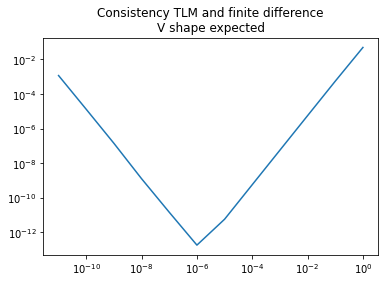

In [ ]:
diff = np.array(diff).reshape(len(alpha_list), N, int(T / dt) + 1)
h_d, q_d, dj = tangent_linear(K0, dK0)
plt.plot(alpha_list, ((diff - h_d)**2).sum(1).sum(1))
plt.yscale('log')
plt.xscale('log')
plt.title(f"Consistency TLM and finite difference\nV shape expected")

In [ ]:
# Check consistency between jacobian matrix and finite differences

jac = jacobian_matrix(K0)


h_t_flat = forward_model(K0).flatten()
fd_jac = np.empty((len(h_t_flat), len(K0)))
print("||jacobian - finite_difference jacobian||")
for alpha in alpha_list:
    for i in range(len(K0)):
        dK0 = np.zeros_like(K0)
        dK0[i] = 1
        fd_jac[:, i] = (forward_model(K0 + alpha * dK0).flatten() - h_t_flat) / alpha
    print(f"{alpha}, {((jac - fd_jac)**2).mean()}")


||jacobian - finite_difference jacobian||
1.0, 9.049048141718492e-07
0.1, 9.877182486303376e-09
0.01, 9.966832822789125e-11
0.001, 9.975870820698896e-13
0.0001, 9.975853411002537e-15
1e-05, 9.957136994079422e-17
1e-06, 1.2795083763635632e-17
1e-07, 1.250452758816632e-15
1e-08, 1.2735431761222155e-13
1e-09, 1.2415442339655803e-11
1e-10, 1.3067099516913804e-09
1e-11, 1.2268280680439656e-07


In [ ]:
# Create a reference trajectory for the SSH
K_truth = np.array([0.2])
h_t = forward_model(K_truth)

yobs = h_t + 0.1*np.random.normal(size=h_t.shape)

In [ ]:
#Create observation matrix
def observation_matrix_init(h_test, ind_to_observe=None):
    if ind_to_observe is None:
        ind_to_observe = range(int(h_test.shape[0]))
    obs_mat = np.zeros((h_test.shape[0], h_test.shape[0]))
    obs_mat[ind_to_observe, ind_to_observe] = 1
    return obs_mat

obs_mat = observation_matrix_init(yobs)

In [ ]:
## Wrapper to compute the cost and the gradient wrt to a reference
def cost_gradient(K, reference):
    simu = sw.ShallowWaterSimulation(D=D, T=T, dt=dt, h0=h0, u0=u0, K=K, bcL = bcL, N=N)
    simu.set_reference(reference)
    simu.cost_fun = lambda x, y: 0.5 * np.mean((x-y)**2)

    simu.obs_mat = obs_mat
    cost, grad = simu.compute_cost_and_gradient()

    grad_sum_length = int(simu.xr.shape[0] / len(K))
    grad_coeff = np.zeros(len(K))
    for i in range(1):
        grad_coeff[i] = sum(
            grad[i * grad_sum_length : (i * grad_sum_length + grad_sum_length)]
            )
    return cost, grad_coeff / np.prod(h_t.shape)

Text(0.5, 1.0, 'Gradient')

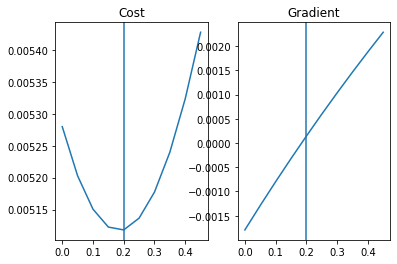

In [ ]:
c_li, g_li = [], []
k_evals = np.arange(10)/20
for k in k_evals:
    c, g = cost_gradient([k], yobs)
    c_li.append(c)
    g_li.append(g)
plt.subplot(1, 2, 1)
plt.plot(k_evals, c_li)
plt.axvline(K_truth)
plt.title('Cost')
plt.subplot(1, 2, 2)
plt.plot(k_evals, g_li)
plt.axvline(K_truth)
plt.title('Gradient')

In [19]:
n_grid = 1
k_ = np.linspace(0, 0.5, n_grid)
K_1, K_2 = np.meshgrid(k_, k_)
K_grid = np.array((K_1, K_2)).T.reshape(-1, 2)
cost_grid = np.empty(len(K_grid))
grad_grid = np.empty(len(K_grid))

k = np.array([0.1, 0.3])
cost2d, grad2d = cost_gradient(k, yobs) 

  0%|          | 0/1 [00:00<?, ?it/s]

[0. 0.]


  0%|          | 0/1 [00:01<?, ?it/s]


NameError: name 'cost_grid' is not defined

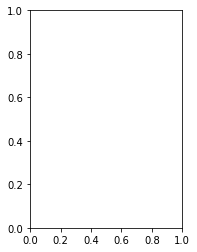

In [ ]:
plt.subplot(1, 2, 1)
plt.contourf(cost_grid.reshape(n_grid, n_grid))
plt.subplot(1, 2, 2)
plt.contourf(grad_grid.reshape(n_grid, n_grid))

In [ ]:
# Consistency check for the gradient and finite differences

k_test_grad = np.random.uniform()
c_test, g_test = cost_gradient([k_test_grad], yobs)
c_eps = []
print(c_test, g_test)
for eps in [1e-3, 1e-5, 1e-7, 1e-9]:
    simu = sw.ShallowWaterSimulation(D=D, T=T, dt=dt, h0=h0, u0=u0, K=[k_test_grad + eps], bcL = bcL, N=N)
    simu.idx_observation = np.arange(len(simu.xr), dtype='int')
    simu.set_reference(yobs)
    cost = simu.compute_cost()
    print(eps, cost, g_test - (cost - c_test) / eps)
    c_eps.append(cost)

0.0059196250826329035 [0.00381999]
0.001 0.005923448641573048 [-3.57220792e-06]
1e-05 0.005919663282857482 [-3.57255955e-08]
1e-07 0.005919625464631606 [-2.94128718e-10]
1e-09 0.00591962508645287 [2.06873517e-08]
